In [3]:
!pip install albumentations opencv-python
!pip install -q ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 24.2 MB/s eta 0:00:00


In [4]:
!rm -rf NoHelmetNet/
!git clone https://github.com/eiglesiasr/NoHelmetNet.git

Cloning into 'NoHelmetNet'...
remote: Enumerating objects: 1413, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 1413 (delta 7), reused 13 (delta 3), pack-reused 1383 (from 3)
Receiving objects: 100% (1413/1413), 285.08 MiB | 43.14 MiB/s, done.
Resolving deltas: 100% (312/312), done.
Updating files: 100% (783/783), done.


In [5]:
#Correr en caso existan previamente imagenes y anotaciones en las rutas
!rm -rf NoHelmetNet/dataset/images
!rm -rf NoHelmetNet/dataset/labels
!mkdir NoHelmetNet/dataset/images
!mkdir NoHelmetNet/dataset/labels
!mkdir NoHelmetNet/dataset/images/train
!mkdir NoHelmetNet/dataset/labels/train
!mkdir NoHelmetNet/dataset/images/test
!mkdir NoHelmetNet/dataset/labels/test

In [22]:
#imports
import json
import os
import shutil
import re
import pandas as pd
from PIL import Image

from sklearn.model_selection import train_test_split
seed = 42


#libs for augmentation
import cv2
import albumentations as A
from tqdm import tqdm

import matplotlib.pyplot as plt


from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [8]:
#cargando json con el encoding de labels a un diccionario
ruta_json='NoHelmetNet/dataset/labelsFineTuning.json'
with open(ruta_json, 'r') as f:
      labels_dict = json.load(f)

In [10]:
ruta_json='NoHelmetNet/raw/Medellin2/anotaciones/'
rows = []

for archivo in os.listdir(ruta_json):
      if archivo.endswith('.json'):
            ruta_archivo = os.path.join(ruta_json, archivo)
            with open(ruta_archivo, 'r', encoding='utf-8') as f:
                  data = json.load(f)
                  image_key = data.get("key")
                  img_width = data.get("width")
                  img_height = data.get("height")

                  match = re.search(r'_(\d+)\.', image_key)
                  frame = int(match.group(1)) if match else None


                  for box in data.get("boxes", []):
                        row = {
                              "file": image_key,
                              "frame": frame,
                              "image_width": img_width,
                              "image_height": img_height,
                              "id": box.get("id"),
                              "label": box.get("label"),
                              "x": float(box.get("x")),
                              "y": float(box.get("y")),
                              "w": float(box.get("width")),
                              "h": float(box.get("height")),
                              "confidence": box.get("confidence")
                        }
                        rows.append(row)

# Convert to DataFrame
df = pd.DataFrame(rows)
df.head()

,file,frame,image_width,image_height,id,label,x,y,w,h,confidence
0,frame_0129.jpg,129,1920,1080,1,DHelmet,209.54,389.80,66.00,89.92,None
1,frame_0129.jpg,129,1920,1080,2,DHelmetP1Helmet,329.16,290.80,67.65,80.02,None
2,frame_0129.jpg,129,1920,1080,3,DHelmetP1Helmet,715.66,395.16,76.72,94.05,None
3,frame_0129.jpg,129,1920,1080,4,DHelmetP1Helmet,776.70,588.61,93.22,117.97,None
4,frame_0129.jpg,129,1920,1080,5,DHelmet,780.42,380.72,84.15,98.17,None


In [11]:
df_imagenes_unicas = df[['file']].drop_duplicates().reset_index(drop=True)
print(f"Imagenes unicas: {len(df_imagenes_unicas)}")

indices_imagenes = df_imagenes_unicas.index

train_indices, test_indices = train_test_split(
    indices_imagenes,
    test_size=0.3,
    random_state=seed
)

df_imagenes_train = df_imagenes_unicas.loc[train_indices].reset_index(drop=True)
df_imagenes_test = df_imagenes_unicas.loc[test_indices].reset_index(drop=True)

print(f"Número de imágenes para entrenamiento: {len(df_imagenes_train)}")
print(f"Número de imágenes para prueba: {len(df_imagenes_test)}")

Imagenes unicas: 126
Número de imágenes para entrenamiento: 88
Número de imágenes para prueba: 38


In [12]:
#chequear que en df_imagenes_train este el file que cotnengan de df la etiqueta DHelmetP1HelmetP2NoHelmet
df_imagenes_train[df_imagenes_train['file'].isin(df[df.label=="DHelmetP1HelmetP2NoHelmet"]['file'])]

,file
5,frame_0122.jpg


In [13]:
img_width = df["image_width"].max()
img_height = df["image_height"].max()
print(f"Images width: {img_width}, Images height: {img_height}")

Images width: 1920, Images height: 1080


In [14]:
#copiando imagenes train a su respectiva carpeta
ruta_origen=r'NoHelmetNet/raw/Medellin2'
ruta_destino_imagenes=r'NoHelmetNet/dataset/images/train'
ruta_destino_anotaciones=r'NoHelmetNet/dataset/labels/train'
image_width=img_width
image_height=img_height
target_size=(640, 640)


for index, row in df_imagenes_train.iterrows():
    #copiando imagen
    file = row['file']
    frame_jpg = row['file'].split('.')[0]
    ruta_imagen_origen = os.path.join(ruta_origen,'imagenes', f'{file}')
    ruta_imagen_destino = os.path.join(ruta_destino_imagenes, f'{file}')
    #shutil.copy(ruta_imagen_origen, ruta_imagen_destino)

    try:
            img = Image.open(ruta_imagen_origen)
            img_resized = img.resize(target_size)
            img_resized.save(ruta_imagen_destino)
    except FileNotFoundError:
        print(f"Warning: Image not found at {ruta_imagen_origen}. Skipping.")
        continue # Saltar a la siguiente imagen si no se encuentra

    #generando anotaciones
    txt_filename = f"{frame_jpg}.txt"
    txt_filepath = os.path.join(ruta_destino_anotaciones, txt_filename)
    for index, row in df[(df.file==file)].iterrows():
        class_id=labels_dict[row['label']]
        #esto era si x y y estaban en esquina y no en centrol
        #x_center = int(row['x']+row['w']/2)
        #y_center = int(row['y']+row['h']/2)

        x_center = row['x']
        y_center = row['y']


        x_center_norm = x_center / image_width
        y_center_norm = y_center / image_height
        width_norm = row['w'] / image_width
        height_norm = row['h'] / image_height

        yolov8_annotation=f"{class_id} {x_center_norm:.6f} {y_center_norm:.6f} {width_norm:.6f} {height_norm:.6f}\n"

        with open(txt_filepath, 'a') as f:
            f.write(yolov8_annotation)


In [15]:
#copiando imagenes test a su respectiva carpeta
ruta_origen=r'NoHelmetNet/raw/Medellin2'
ruta_destino_imagenes=r'NoHelmetNet/dataset/images/test'
ruta_destino_anotaciones=r'NoHelmetNet/dataset/labels/test'
image_width=img_width
image_height=img_height
target_size=(640, 640)


for index, row in df_imagenes_test.iterrows():
    #copiando imagen
    file = row['file']
    frame_jpg = row['file'].split('.')[0]
    ruta_imagen_origen = os.path.join(ruta_origen,'imagenes', f'{file}')
    ruta_imagen_destino = os.path.join(ruta_destino_imagenes, f'{file}')
    #shutil.copy(ruta_imagen_origen, ruta_imagen_destino)

    try:
            img = Image.open(ruta_imagen_origen)
            img_resized = img.resize(target_size)
            img_resized.save(ruta_imagen_destino)
    except FileNotFoundError:
        print(f"Warning: Image not found at {ruta_imagen_origen}. Skipping.")
        continue # Saltar a la siguiente imagen si no se encuentra

    #generando anotaciones
    txt_filename = f"{frame_jpg}.txt"
    txt_filepath = os.path.join(ruta_destino_anotaciones, txt_filename)
    for index, row in df[(df.file==file)].iterrows():
        class_id=labels_dict[row['label']]
        #esto era si x y y estaban en esquina y no en centrol
        #x_center = int(row['x']+row['w']/2)
        #y_center = int(row['y']+row['h']/2)

        x_center = row['x']
        y_center = row['y']


        x_center_norm = x_center / image_width
        y_center_norm = y_center / image_height
        width_norm = row['w'] / image_width
        height_norm = row['h'] / image_height

        yolov8_annotation=f"{class_id} {x_center_norm:.6f} {y_center_norm:.6f} {width_norm:.6f} {height_norm:.6f}\n"

        with open(txt_filepath, 'a') as f:
            f.write(yolov8_annotation)


In [16]:
#data augmentation en train
image_dir = "NoHelmetNet/dataset/images/train"
label_dir = "NoHelmetNet/dataset/labels/train"
aug_img_dir = "NoHelmetNet/dataset/images/train"
aug_lbl_dir = "NoHelmetNet/dataset/labels/train"

transform = A.Compose([
    A.RandomBrightnessContrast(p=0.7),
    A.MotionBlur(blur_limit=3, p=0.4),
    A.Rotate(limit=15, p=0.5),
    A.RandomScale(scale_limit=0.3, p=0.5),
    A.Perspective(scale=(0.05, 0.1), p=0.4),
    A.HorizontalFlip(p=0.5),
    A.RandomSizedBBoxSafeCrop(height=640, width=640, p=0.3),
    A.ColorJitter(p=0.3)
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

# Número de augmentations por imagen
N = 30


In [17]:
for filename in tqdm(os.listdir(image_dir)):
    if not filename.endswith(".jpg"):
        continue

    base_name = os.path.splitext(filename)[0]
    img_path = os.path.join(image_dir, filename)
    label_path = os.path.join(label_dir, base_name + ".txt")

    try:
        # Leer imagen
        image = cv2.imread(img_path)
        h, w = image.shape[:2]

        # Leer anotaciones en formato YOLO
        bboxes = []
        class_labels = []
        with open(label_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                cls = int(parts[0])
                x, y, bw, bh = map(float, parts[1:])
                bboxes.append([x, y, bw, bh])
                class_labels.append(cls)

        for i in range(N):
            try:
                transformed = transform(image=image, bboxes=bboxes, class_labels=class_labels)

                aug_img = transformed["image"]
                aug_bboxes = transformed["bboxes"]
                aug_labels = transformed["class_labels"]

                # Guardar imagen
                out_img_name = f"{base_name}_aug_{i}.jpg"
                out_img_path = os.path.join(aug_img_dir, out_img_name)
                cv2.imwrite(out_img_path, aug_img)

                # Guardar anotaciones
                out_lbl_path = os.path.join(aug_lbl_dir, f"{base_name}_aug_{i}.txt")
                with open(out_lbl_path, "w") as f:
                    for box, cls in zip(aug_bboxes, aug_labels):
                        f.write(f"{int(cls)} {' '.join(f'{coord:.6f}' for coord in box)}\n")
            except ValueError as e:
                print(f"Error processing augmentation {i} for image {filename}: {e}")

    except Exception as e:
        print(f"Error processing image {filename}: {e}")

 32%|███▏      | 28/88 [00:09<00:18,  3.21it/s]

Error processing augmentation 0 for image frame_0123.jpg: Expected x_min for bbox [-2.4996698e-06  3.0731452e-01  5.5408500e-02  4.4699949e-01
  2.0000000e+00] to be in the range [0.0, 1.0], got -2.4996697902679443e-06.
Error processing augmentation 1 for image frame_0123.jpg: Expected x_min for bbox [-2.4996698e-06  3.0731452e-01  5.5408500e-02  4.4699949e-01
  2.0000000e+00] to be in the range [0.0, 1.0], got -2.4996697902679443e-06.
Error processing augmentation 2 for image frame_0123.jpg: Expected x_min for bbox [-2.4996698e-06  3.0731452e-01  5.5408500e-02  4.4699949e-01
  2.0000000e+00] to be in the range [0.0, 1.0], got -2.4996697902679443e-06.
Error processing augmentation 3 for image frame_0123.jpg: Expected x_min for bbox [-2.4996698e-06  3.0731452e-01  5.5408500e-02  4.4699949e-01
  2.0000000e+00] to be in the range [0.0, 1.0], got -2.4996697902679443e-06.
Error processing augmentation 4 for image frame_0123.jpg: Expected x_min for bbox [-2.4996698e-06  3.0731452e-01  5.5408

 39%|███▊      | 34/88 [00:11<00:17,  3.09it/s]

Error processing augmentation 0 for image frame_0103.jpg: Expected x_min for bbox [-2.4996698e-06  3.7169451e-01  4.3898501e-02  4.8015749e-01
  1.0000000e+00] to be in the range [0.0, 1.0], got -2.4996697902679443e-06.
Error processing augmentation 1 for image frame_0103.jpg: Expected x_min for bbox [-2.4996698e-06  3.7169451e-01  4.3898501e-02  4.8015749e-01
  1.0000000e+00] to be in the range [0.0, 1.0], got -2.4996697902679443e-06.
Error processing augmentation 2 for image frame_0103.jpg: Expected x_min for bbox [-2.4996698e-06  3.7169451e-01  4.3898501e-02  4.8015749e-01
  1.0000000e+00] to be in the range [0.0, 1.0], got -2.4996697902679443e-06.
Error processing augmentation 3 for image frame_0103.jpg: Expected x_min for bbox [-2.4996698e-06  3.7169451e-01  4.3898501e-02  4.8015749e-01
  1.0000000e+00] to be in the range [0.0, 1.0], got -2.4996697902679443e-06.
Error processing augmentation 4 for image frame_0103.jpg: Expected x_min for bbox [-2.4996698e-06  3.7169451e-01  4.3898

 81%|████████  | 71/88 [00:23<00:05,  3.11it/s]

Error processing augmentation 0 for image frame_0151.jpg: Expected x_min for bbox [-2.4996698e-06  3.4934300e-01  3.1252500e-02  4.6006501e-01
  1.0000000e+00] to be in the range [0.0, 1.0], got -2.4996697902679443e-06.
Error processing augmentation 1 for image frame_0151.jpg: Expected x_min for bbox [-2.4996698e-06  3.4934300e-01  3.1252500e-02  4.6006501e-01
  1.0000000e+00] to be in the range [0.0, 1.0], got -2.4996697902679443e-06.
Error processing augmentation 2 for image frame_0151.jpg: Expected x_min for bbox [-2.4996698e-06  3.4934300e-01  3.1252500e-02  4.6006501e-01
  1.0000000e+00] to be in the range [0.0, 1.0], got -2.4996697902679443e-06.
Error processing augmentation 3 for image frame_0151.jpg: Expected x_min for bbox [-2.4996698e-06  3.4934300e-01  3.1252500e-02  4.6006501e-01
  1.0000000e+00] to be in the range [0.0, 1.0], got -2.4996697902679443e-06.
Error processing augmentation 4 for image frame_0151.jpg: Expected x_min for bbox [-2.4996698e-06  3.4934300e-01  3.1252

 85%|████████▌ | 75/88 [00:24<00:05,  2.40it/s]

Error processing augmentation 0 for image frame_0111.jpg: Expected x_min for bbox [-2.9988587e-06  5.0396752e-01  4.7617000e-02  6.1905050e-01
  1.0000000e+00] to be in the range [0.0, 1.0], got -2.998858690261841e-06.
Error processing augmentation 1 for image frame_0111.jpg: Expected x_min for bbox [-2.9988587e-06  5.0396752e-01  4.7617000e-02  6.1905050e-01
  1.0000000e+00] to be in the range [0.0, 1.0], got -2.998858690261841e-06.
Error processing augmentation 2 for image frame_0111.jpg: Expected x_min for bbox [-2.9988587e-06  5.0396752e-01  4.7617000e-02  6.1905050e-01
  1.0000000e+00] to be in the range [0.0, 1.0], got -2.998858690261841e-06.
Error processing augmentation 3 for image frame_0111.jpg: Expected x_min for bbox [-2.9988587e-06  5.0396752e-01  4.7617000e-02  6.1905050e-01
  1.0000000e+00] to be in the range [0.0, 1.0], got -2.998858690261841e-06.
Error processing augmentation 4 for image frame_0111.jpg: Expected x_min for bbox [-2.9988587e-06  5.0396752e-01  4.7617000e

 89%|████████▊ | 78/88 [00:25<00:03,  2.83it/s]

Error processing augmentation 0 for image frame_0049.jpg: Expected x_min for bbox [-1.9967556e-06  6.0581899e-01  6.4732000e-02  7.3942101e-01
  1.0000000e+00] to be in the range [0.0, 1.0], got -1.996755599975586e-06.
Error processing augmentation 1 for image frame_0049.jpg: Expected x_min for bbox [-1.9967556e-06  6.0581899e-01  6.4732000e-02  7.3942101e-01
  1.0000000e+00] to be in the range [0.0, 1.0], got -1.996755599975586e-06.
Error processing augmentation 2 for image frame_0049.jpg: Expected x_min for bbox [-1.9967556e-06  6.0581899e-01  6.4732000e-02  7.3942101e-01
  1.0000000e+00] to be in the range [0.0, 1.0], got -1.996755599975586e-06.
Error processing augmentation 3 for image frame_0049.jpg: Expected x_min for bbox [-1.9967556e-06  6.0581899e-01  6.4732000e-02  7.3942101e-01
  1.0000000e+00] to be in the range [0.0, 1.0], got -1.996755599975586e-06.
Error processing augmentation 4 for image frame_0049.jpg: Expected x_min for bbox [-1.9967556e-06  6.0581899e-01  6.4732000e

 91%|█████████ | 80/88 [00:26<00:02,  3.67it/s]

Error processing augmentation 0 for image frame_0109.jpg: Expected x_min for bbox [-2.4996698e-06  6.4689851e-01  6.0242500e-02  7.5830555e-01
  1.0000000e+00] to be in the range [0.0, 1.0], got -2.4996697902679443e-06.
Error processing augmentation 1 for image frame_0109.jpg: Expected x_min for bbox [-2.4996698e-06  6.4689851e-01  6.0242500e-02  7.5830555e-01
  1.0000000e+00] to be in the range [0.0, 1.0], got -2.4996697902679443e-06.
Error processing augmentation 2 for image frame_0109.jpg: Expected x_min for bbox [-2.4996698e-06  6.4689851e-01  6.0242500e-02  7.5830555e-01
  1.0000000e+00] to be in the range [0.0, 1.0], got -2.4996697902679443e-06.
Error processing augmentation 3 for image frame_0109.jpg: Expected x_min for bbox [-2.4996698e-06  6.4689851e-01  6.0242500e-02  7.5830555e-01
  1.0000000e+00] to be in the range [0.0, 1.0], got -2.4996697902679443e-06.
Error processing augmentation 4 for image frame_0109.jpg: Expected x_min for bbox [-2.4996698e-06  6.4689851e-01  6.0242

100%|██████████| 88/88 [00:28<00:00,  3.10it/s]


In [18]:
!ls /content/NoHelmetNet/dataset/labels/train | wc -l
!ls /content/NoHelmetNet/dataset/images/train | wc -l
!ls /content/NoHelmetNet/dataset/labels/test | wc -l
!ls /content/NoHelmetNet/dataset/images/test | wc -l


2548
2548
38
38


In [19]:
#testeando labels en data augmentation
def draw_boxes(image_file, label_file):
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    h, w, _ = image.shape

    if os.path.exists(label_file):
        with open(label_file, 'r') as f:
            for line in f.readlines():
                parts = line.strip().split()
                class_id = int(parts[0])
                x_center, y_center, bw, bh = map(float, parts[1:])

                # Convertir a coordenadas de esquina
                x1 = int((x_center - bw / 2) * w)
                y1 = int((y_center - bh / 2) * h)
                x2 = int((x_center + bw / 2) * w)
                y2 = int((y_center + bh / 2) * h)

                # Dibujar rectángulo
                cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
                cv2.putText(image, str(class_id), (x1, y1 - 5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

    # Mostrar imagen
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

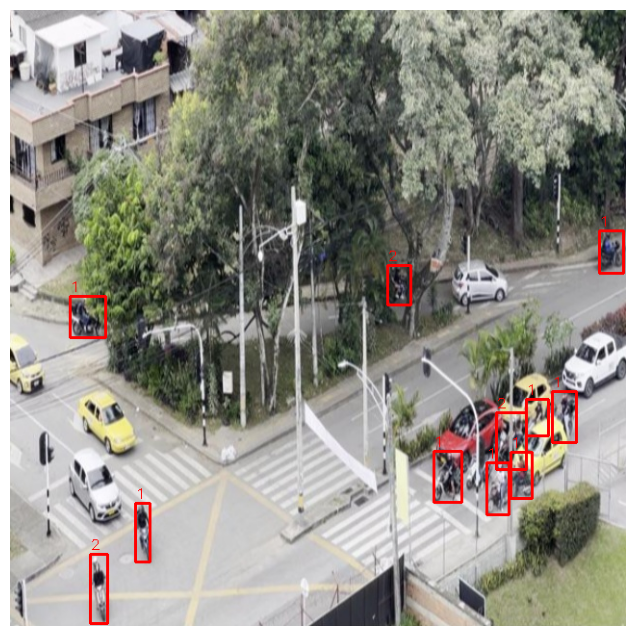

In [20]:
image_dir = "NoHelmetNet/dataset/images/train"
label_dir = "NoHelmetNet/dataset/labels/train"
filename ='frame_0040_aug_20.jpg'
image_file = os.path.join(image_dir, filename)
label_file = os.path.join(label_dir, os.path.splitext(filename)[0] + ".txt")
draw_boxes(image_file, label_file)

In [24]:
#cargando modelo yolo pre-entrenado y haciendole finetunning con imagenes de medellin
model = YOLO("NoHelmetNet/results/yolo_train/expUltimaVersion/weights/best.pt")

model.train(
    data='NoHelmetNet/dataset/dataFineTuningMDE.yaml',
    epochs=50,
    imgsz=640,
    batch=16,
    name="yolo_finetune_medellin",
    pretrained=True,
    resume=False
)

Ultralytics 8.3.147 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=NoHelmetNet/dataset/dataFineTuningMDE.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=NoHelmetNet/results/yolo_train/expUltimaVersion/weights/best.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo_finetune_medellin, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto,

100%|██████████| 755k/755k [00:00<00:00, 21.4MB/s]

Overriding model.yaml nc=36 with nc=7

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Model summary: 129 layers, 3,012,213 parameters, 3,012,197 gradients, 8.2 GFLOPs

Transferred 349/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 88.1MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2166.3±1433.2 MB/s, size: 166.5 KB)


train: Scanning /content/NoHelmetNet/dataset/labels/train... 2548 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2548/2548 [00:01<00:00, 2494.13it/s]

train: /content/NoHelmetNet/dataset/images/train/frame_0000.jpg: 10 duplicate labels removed
train: /content/NoHelmetNet/dataset/images/train/frame_0000_aug_0.jpg: 10 duplicate labels removed
train: /content/NoHelmetNet/dataset/images/train/frame_0000_aug_1.jpg: 9 duplicate labels removed
train: /content/NoHelmetNet/dataset/images/train/frame_0000_aug_10.jpg: 8 duplicate labels removed
train: /content/NoHelmetNet/dataset/images/train/frame_0000_aug_11.jpg: 10 duplicate labels removed
train: /content/NoHelmetNet/dataset/images/train/frame_0000_aug_12.jpg: 10 duplicate labels removed
train: /content/NoHelmetNet/dataset/images/train/frame_0000_aug_13.jpg: 10 duplicate labels removed
train: /content/NoHelmetNet/dataset/images/train/frame_0000_aug_14.jpg: 9 duplicate labels removed
train: /content/NoHelmetNet/dataset/images/train/frame_0000_aug_15.jpg: 10 duplicate labels removed
train: /content/NoHelmetNet/dataset/images/train/frame_0000_aug_16.jpg: 10 duplicate labels removed
train: /cont

val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 932.6±460.5 MB/s, size: 92.9 KB)


val: Scanning /content/NoHelmetNet/dataset/labels/test... 38 images, 0 backgrounds, 0 corrupt: 100%|██████████| 38/38 [00:00<00:00, 1542.08it/s]

val: New cache created: /content/NoHelmetNet/dataset/labels/test.cache


Plotting labels to runs/detect/yolo_finetune_medellin/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/yolo_finetune_medellin
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.22G      1.806      2.829      1.419         26        640: 100%|██████████| 160/160 [00:48<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]

                   all         38        251      0.716      0.218       0.26      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50       2.7G      1.443      1.501      1.165         19        640: 100%|██████████| 160/160 [00:44<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]

                   all         38        251      0.383      0.483       0.46      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.71G      1.321      1.233      1.115         27        640: 100%|██████████| 160/160 [00:43<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.30it/s]


                   all         38        251      0.434      0.686      0.581      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.73G      1.231       1.07      1.079         39        640: 100%|██████████| 160/160 [00:44<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.82it/s]

                   all         38        251      0.673      0.578       0.55      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.74G      1.193     0.9639      1.054         35        640: 100%|██████████| 160/160 [00:42<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.30it/s]

                   all         38        251      0.483      0.692      0.592      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.76G      1.172     0.9061      1.039         44        640: 100%|██████████| 160/160 [00:43<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.20it/s]

                   all         38        251      0.532      0.657      0.626      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.78G      1.111     0.8247      1.019         41        640: 100%|██████████| 160/160 [00:42<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.39it/s]

                   all         38        251      0.844      0.589      0.733      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50       2.8G      1.091     0.7792      1.009         18        640: 100%|██████████| 160/160 [00:43<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.77it/s]

                   all         38        251      0.532       0.64      0.553      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.81G      1.072     0.7428      1.003         28        640: 100%|██████████| 160/160 [00:43<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.98it/s]

                   all         38        251      0.456      0.744      0.637      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.83G      1.047     0.7204     0.9889         28        640: 100%|██████████| 160/160 [00:42<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.35it/s]

                   all         38        251      0.602      0.599      0.673       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.85G      1.029     0.6856     0.9902         33        640: 100%|██████████| 160/160 [00:43<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.51it/s]

                   all         38        251       0.47      0.672       0.68      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.87G      1.009     0.6627     0.9776         33        640: 100%|██████████| 160/160 [00:42<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.32it/s]

                   all         38        251      0.503      0.699      0.592      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.88G     0.9877     0.6427       0.97         38        640: 100%|██████████| 160/160 [00:42<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.35it/s]

                   all         38        251      0.791      0.628      0.698      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50       2.9G     0.9717     0.6321     0.9625         21        640: 100%|██████████| 160/160 [00:43<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.61it/s]

                   all         38        251      0.777       0.63       0.69      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.91G      0.961     0.6253     0.9603         24        640: 100%|██████████| 160/160 [00:42<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.44it/s]

                   all         38        251      0.663      0.602      0.682       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.93G     0.9302     0.5984     0.9516         23        640: 100%|██████████| 160/160 [00:43<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.95it/s]

                   all         38        251       0.86      0.631      0.695      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.95G     0.9442     0.5903     0.9539         25        640: 100%|██████████| 160/160 [00:42<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]

                   all         38        251      0.633      0.663      0.589      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.97G     0.9278     0.5835     0.9481         32        640: 100%|██████████| 160/160 [00:43<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]

                   all         38        251      0.684      0.647      0.714      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.98G     0.9004     0.5665     0.9359         35        640: 100%|██████████| 160/160 [00:43<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.27it/s]


                   all         38        251      0.569      0.752      0.619      0.465

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         3G     0.9116     0.5639     0.9403         24        640: 100%|██████████| 160/160 [00:43<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.23it/s]

                   all         38        251      0.489      0.725      0.614      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      3.02G     0.8926     0.5524     0.9378         12        640: 100%|██████████| 160/160 [00:43<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.21it/s]

                   all         38        251      0.473        0.7      0.605      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      3.04G     0.8772     0.5425     0.9355         12        640: 100%|██████████| 160/160 [00:42<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.74it/s]

                   all         38        251      0.646      0.623      0.601      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.05G     0.8802      0.544     0.9344         40        640: 100%|██████████| 160/160 [00:44<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.24it/s]

                   all         38        251      0.497      0.701      0.599      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      3.07G     0.8687     0.5366     0.9325         40        640: 100%|██████████| 160/160 [00:43<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.18it/s]

                   all         38        251      0.866      0.477      0.569       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      3.09G     0.8619     0.5289     0.9269         43        640: 100%|██████████| 160/160 [00:44<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.72it/s]

                   all         38        251      0.365      0.724      0.554      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50       3.1G     0.8499     0.5175     0.9239         29        640: 100%|██████████| 160/160 [00:43<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.42it/s]


                   all         38        251      0.419      0.716      0.581      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      3.12G     0.8577     0.5235     0.9273         13        640: 100%|██████████| 160/160 [00:43<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.60it/s]


                   all         38        251      0.466      0.684      0.587      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      3.14G     0.8337     0.5091     0.9196         24        640: 100%|██████████| 160/160 [00:43<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.32it/s]

                   all         38        251      0.714      0.652      0.583      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.15G     0.8328     0.5088     0.9171         49        640: 100%|██████████| 160/160 [00:42<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.34it/s]


                   all         38        251      0.433      0.685      0.595       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.17G     0.8149     0.5013     0.9143         45        640: 100%|██████████| 160/160 [00:44<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.35it/s]

                   all         38        251      0.474      0.698      0.605       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      3.19G     0.8115     0.4945     0.9116         27        640: 100%|██████████| 160/160 [00:42<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.81it/s]

                   all         38        251      0.513      0.662      0.586      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      3.21G     0.8125     0.4925     0.9124         18        640: 100%|██████████| 160/160 [00:43<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]

                   all         38        251      0.761      0.656      0.703      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.22G      0.796     0.4851     0.9069         50        640: 100%|██████████| 160/160 [00:43<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.69it/s]

                   all         38        251      0.452      0.686      0.577      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      3.24G     0.7888     0.4816     0.9072         27        640: 100%|██████████| 160/160 [00:44<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.22it/s]

                   all         38        251      0.445      0.737      0.607      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      3.26G     0.7874     0.4744     0.9039         15        640: 100%|██████████| 160/160 [00:43<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.34it/s]

                   all         38        251      0.479      0.676      0.613      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      3.28G     0.7756      0.471     0.9049         21        640: 100%|██████████| 160/160 [00:42<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.12it/s]

                   all         38        251      0.542      0.679      0.623      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.29G     0.7828     0.4706     0.9073         23        640: 100%|██████████| 160/160 [00:43<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.48it/s]

                   all         38        251      0.501      0.684      0.595      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      3.31G     0.7744     0.4696     0.9044         18        640: 100%|██████████| 160/160 [00:43<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.75it/s]

                   all         38        251      0.473      0.692      0.605      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      3.32G     0.7616     0.4654     0.9015         44        640: 100%|██████████| 160/160 [00:43<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]

                   all         38        251      0.514      0.692      0.614      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      3.34G     0.7627      0.458     0.8995         35        640: 100%|██████████| 160/160 [00:44<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

                   all         38        251      0.533      0.688      0.593      0.443


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      3.36G     0.6973     0.3909     0.8846         18        640: 100%|██████████| 160/160 [00:42<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.27it/s]

                   all         38        251      0.661       0.66      0.595      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      3.38G      0.681     0.3798     0.8771         17        640: 100%|██████████| 160/160 [00:41<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.40it/s]

                   all         38        251      0.511      0.649      0.598      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      3.39G     0.6627     0.3703     0.8741         28        640: 100%|██████████| 160/160 [00:40<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.40it/s]


                   all         38        251      0.516      0.684      0.605      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      3.41G     0.6563     0.3708      0.873         26        640: 100%|██████████| 160/160 [00:41<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.05it/s]

                   all         38        251      0.748      0.641      0.598      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      3.43G     0.6513     0.3661     0.8704         29        640: 100%|██████████| 160/160 [00:41<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.33it/s]

                   all         38        251      0.567      0.648      0.589      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      3.44G      0.641     0.3591     0.8714         23        640: 100%|██████████| 160/160 [00:41<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.77it/s]

                   all         38        251      0.709      0.649       0.59      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.46G     0.6417     0.3612      0.872         11        640: 100%|██████████| 160/160 [00:41<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.74it/s]

                   all         38        251      0.705      0.645      0.581       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.48G     0.6352     0.3573     0.8675         13        640: 100%|██████████| 160/160 [00:41<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.74it/s]

                   all         38        251      0.478      0.672      0.588      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50       3.5G     0.6303     0.3538     0.8665         18        640: 100%|██████████| 160/160 [00:41<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.93it/s]

                   all         38        251      0.657      0.643      0.585      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      3.51G     0.6297     0.3584     0.8658         12        640: 100%|██████████| 160/160 [00:40<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.55it/s]

                   all         38        251      0.655       0.65      0.585      0.435



50 epochs completed in 0.613 hours.
Optimizer stripped from runs/detect/yolo_finetune_medellin/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/yolo_finetune_medellin/weights/best.pt, 6.3MB

Validating runs/detect/yolo_finetune_medellin/weights/best.pt...
Ultralytics 8.3.147 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,007,013 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.28it/s]


                   all         38        251      0.844      0.589      0.733      0.527
             DNoHelmet         12         12      0.825        0.5      0.645      0.479
               DHelmet         36        156       0.93      0.771      0.933      0.698
       DHelmetP1Helmet         30         72      0.832      0.764      0.904       0.64
DNoHelmetP1NoHelmetP2NoHelmet          1          1       0.93          1      0.995      0.597
     DHelmetP1NoHelmet          4          4          1          0      0.157     0.0892
   DNoHelmetP1NoHelmet          6          6      0.547        0.5      0.761      0.656
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/yolo_finetune_medellin


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d7fcd2e1550>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
     

In [34]:
#guardar modelo en zip
!zip -r yolo_finetune_medellin.zip runs/detect/yolo_finetune_medellin


  adding: runs/detect/yolo_finetune_medellin/ (stored 0%)
  adding: runs/detect/yolo_finetune_medellin/train_batch1.jpg (deflated 2%)
  adding: runs/detect/yolo_finetune_medellin/results.csv (deflated 62%)
  adding: runs/detect/yolo_finetune_medellin/weights/ (stored 0%)
  adding: runs/detect/yolo_finetune_medellin/weights/last.pt (deflated 9%)
  adding: runs/detect/yolo_finetune_medellin/weights/best.pt (deflated 9%)
  adding: runs/detect/yolo_finetune_medellin/R_curve.png (deflated 9%)
  adding: runs/detect/yolo_finetune_medellin/val_batch1_pred.jpg (deflated 6%)
  adding: runs/detect/yolo_finetune_medellin/labels.jpg (deflated 27%)
  adding: runs/detect/yolo_finetune_medellin/train_batch6401.jpg (deflated 4%)
  adding: runs/detect/yolo_finetune_medellin/val_batch0_labels.jpg (deflated 4%)
  adding: runs/detect/yolo_finetune_medellin/confusion_matrix_normalized.png (deflated 19%)
  adding: runs/detect/yolo_finetune_medellin/val_batch1_labels.jpg (deflated 6%)
  adding: runs/detect/yo